# **Project Setup**

**TaxiScope** leverages Apache Spark to analyze NYC taxi trip data, uncovering trends like peak demand hours, fare distributions, and high-revenue zones. The project includes machine learning models to predict fares based on trip details and clustering to identify hotspots, offering scalable insights for smarter transportation planning.

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
# Replace 'your_dataset.csv' with the path or URL to your dataset
file_path = 'taxi_tripdata.csv'
data = pd.read_csv(file_path)

# Basic insights about the dataset
print("Shape of the dataset (rows, columns):", data.shape)

print("\nColumns in the dataset:")
print(data.columns)

print("\nSummary of the dataset:")
print(data.info())

print("\nFirst few rows of the dataset:")
print(data.head())

print("\nStatistical Summary of numerical columns:")
print(data.describe())


<ipython-input-1-6df4c903d2f8>:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Shape of the dataset (rows, columns): (83691, 20)

Columns in the dataset:
Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83691 entries, 0 to 83690
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               51173 non-null  float64
 1   lpep_pickup_datetime   83691 non-null  object 
 2   lpep_dropoff_datetime  83691 non-null  object 
 3   store_and_fwd_flag     51173 non-null  object 
 4   RatecodeID             51173 non-null  float64
 5   PULocationID           8369

**Install and Configure PySpark in Colab**

In [2]:
# Install PySpark
!pip install pyspark

# Verify installation
import pyspark
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Trip Analysis") \
    .getOrCreate()

# Confirm Spark is running
print("Apache Spark setup completed successfully!")
print(f"Spark version: {spark.version}")


Apache Spark setup completed successfully!
Spark version: 3.5.4


**Load the Dataset**

In [3]:
# Provide the path to your dataset (CSV format)
file_path = 'taxi_tripdata.csv'  # Replace with the actual file path or upload the dataset to Colab

# Load the dataset into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the dataset
print("First 5 rows of the dataset:")
df.show(5)

# Print the schema of the DataFrame
print("\nSchema of the dataset:")
df.printSchema()


First 5 rows of the dataset:
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       1| 2021-07-01 00:30:52|  2021-07-01 00:35:36|                 N|         1|          74|         168|              1|         

**Basic Statistics and Data Exploration**

In [4]:
# Get basic statistics for numerical columns
print("Summary statistics for numerical columns:")
df.describe().show()

# Check for null values in each column
print("Count of null values in each column:")
for column in df.columns:
    null_count = df.filter(df[column].isNull()).count()
    print(f"{column}: {null_count} null values")


Summary statistics for numerical columns:
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------+---------------------+------------------+------------------+------------------+--------------------+
|summary|          VendorID|store_and_fwd_flag|        RatecodeID|      PULocationID|      DOLocationID|   passenger_count|     trip_distance|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|ehail_fee|improvement_surcharge|      total_amount|      payment_type|         trip_type|congestion_surcharge|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------+------------

# **Data Cleaning**

In [5]:
from pyspark.sql.functions import to_timestamp

# Step 1: Drop rows with missing or null values in key columns
df = df.dropna(subset=["trip_distance", "fare_amount", "passenger_count", "RatecodeID", "payment_type"])

# Step 2: Parse date columns into proper datetime format
df = df.withColumn("pickup_datetime", to_timestamp("lpep_pickup_datetime"))
df = df.withColumn("dropoff_datetime", to_timestamp("lpep_dropoff_datetime"))

# Step 3: Remove outliers
df = df.filter(
    (df["fare_amount"] > 0) &
    (df["trip_distance"] > 0) &
    (df["trip_distance"] < 1000) &  # Realistic upper limit for trip_distance
    (df["passenger_count"] > 0) &
    (df["passenger_count"] <= 10)  # Reasonable max passenger count
)

# Show the first few rows after cleaning
print("First 5 rows after cleaning:")
df.show(5)

# Print the schema and row count after cleaning
print("\nSchema and row count after cleaning:")
df.printSchema()
print(f"Row count: {df.count()}")


First 5 rows after cleaning:
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-------------------+-------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|    pickup_datetime|   dropoff_datetime|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+-------------------+-------------------+
|       1| 202

# **Summary Statistics - Key Metrics**

**Calculate Average Trip Distance and Duration**

In [8]:
from pyspark.sql.functions import unix_timestamp

# Calculate trip duration in minutes
df = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60
)

# Verify the column was added successfully
print("First 5 rows with trip_duration_minutes:")
df.select("pickup_datetime", "dropoff_datetime", "trip_duration_minutes").show(5)


First 5 rows with trip_duration_minutes:
+-------------------+-------------------+---------------------+
|    pickup_datetime|   dropoff_datetime|trip_duration_minutes|
+-------------------+-------------------+---------------------+
|2021-07-01 00:30:52|2021-07-01 00:35:36|    4.733333333333333|
|2021-07-01 00:25:36|2021-07-01 01:01:31|   35.916666666666664|
|2021-07-01 00:05:58|2021-07-01 00:12:00|    6.033333333333333|
|2021-07-01 00:41:40|2021-07-01 00:47:23|    5.716666666666667|
|2021-07-01 00:51:32|2021-07-01 00:58:46|    7.233333333333333|
+-------------------+-------------------+---------------------+
only showing top 5 rows



**Calculate Average Trip Distance and Duration**

In [9]:
from pyspark.sql.functions import avg

# Calculate average trip distance and duration
avg_metrics = df.select(
    avg("trip_distance").alias("avg_trip_distance"),
    avg("trip_duration_minutes").alias("avg_trip_duration")
)

# Show the results
print("Average trip distance and duration:")
avg_metrics.show()


Average trip distance and duration:
+-----------------+------------------+
|avg_trip_distance| avg_trip_duration|
+-----------------+------------------+
|3.668714071794014|23.566318996713917|
+-----------------+------------------+



**Analyze the Distribution of Fares**

In [11]:
from pyspark.sql.functions import col, count, when

# Group by fare ranges for distribution
fare_distribution = df.select("fare_amount").groupBy(
    when(col("fare_amount") < 10, "< $10")
    .when((col("fare_amount") >= 10) & (col("fare_amount") < 20), "$10 - $20")
    .when((col("fare_amount") >= 20) & (col("fare_amount") < 50), "$20 - $50")
    .otherwise(">= $50").alias("fare_range")
).agg(count("*").alias("count"))

# Show the distribution
print("Fare distribution:")
fare_distribution.show()


Fare distribution:
+----------+-----+
|fare_range|count|
+----------+-----+
|     < $10|21970|
| $10 - $20|16758|
|    >= $50| 2081|
| $20 - $50| 7273|
+----------+-----+



**Analyze the Distribution of Passenger Counts**

In [12]:
# Group by passenger count for distribution
passenger_distribution = df.groupBy("passenger_count").agg(count("*").alias("count"))

# Show the passenger count distribution
print("Passenger count distribution:")
passenger_distribution.orderBy("passenger_count").show()


Passenger count distribution:
+---------------+-----+
|passenger_count|count|
+---------------+-----+
|              1|41295|
|              2| 3779|
|              3|  597|
|              4|  177|
|              5| 1215|
|              6| 1017|
|              7|    2|
+---------------+-----+



**Analyze Trip Demand by Hour of the Day**

In [13]:
from pyspark.sql.functions import hour

# Extract hour from the pickup_datetime column
df = df.withColumn("pickup_hour", hour("pickup_datetime"))

# Group by pickup hour to calculate trip demand
hourly_demand = df.groupBy("pickup_hour").agg(count("*").alias("trip_count"))

# Show hourly trip demand
print("Hourly trip demand:")
hourly_demand.orderBy("pickup_hour").show()


Hourly trip demand:
+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|          0|       757|
|          1|       513|
|          2|       347|
|          3|       277|
|          4|       222|
|          5|       349|
|          6|       921|
|          7|      1676|
|          8|      2513|
|          9|      2697|
|         10|      2905|
|         11|      2968|
|         12|      2884|
|         13|      2720|
|         14|      3129|
|         15|      3529|
|         16|      3385|
|         17|      3446|
|         18|      3697|
|         19|      3043|
+-----------+----------+
only showing top 20 rows



**Analyze Busiest Pick-Up and Drop-Off Locations**

In [14]:
from pyspark.sql.functions import desc

# Group by PULocationID (Pick-Up Location) and DOLocationID (Drop-Off Location)
pickup_demand = df.groupBy("PULocationID").agg(count("*").alias("pickup_count")).orderBy(desc("pickup_count"))
dropoff_demand = df.groupBy("DOLocationID").agg(count("*").alias("dropoff_count")).orderBy(desc("dropoff_count"))

# Show top 5 busiest pick-up locations
print("Top 5 busiest pick-up locations:")
pickup_demand.show(5)

# Show top 5 busiest drop-off locations
print("Top 5 busiest drop-off locations:")
dropoff_demand.show(5)


Top 5 busiest pick-up locations:
+------------+------------+
|PULocationID|pickup_count|
+------------+------------+
|          74|        8047|
|          75|        7002|
|          41|        4093|
|          42|        2350|
|         166|        2087|
+------------+------------+
only showing top 5 rows

Top 5 busiest drop-off locations:
+------------+-------------+
|DOLocationID|dropoff_count|
+------------+-------------+
|          74|         3102|
|          75|         2531|
|          42|         2295|
|          41|         2146|
|         236|         1483|
+------------+-------------+
only showing top 5 rows



**Analyze Total Revenue by Day**

In [15]:
from pyspark.sql.functions import date_format, sum

# Extract date from pickup_datetime
df = df.withColumn("pickup_date", date_format("pickup_datetime", "yyyy-MM-dd"))

# Group by pickup_date to calculate total revenue
daily_revenue = df.groupBy("pickup_date").agg(sum("fare_amount").alias("total_revenue"))

# Show total revenue by day
print("Total revenue by day:")
daily_revenue.orderBy("pickup_date").show(5)  # Show the first 5 days


Total revenue by day:
+-----------+-------------+
|pickup_date|total_revenue|
+-----------+-------------+
| 2008-12-31|         10.5|
| 2009-01-01|         89.5|
| 2021-06-07|         56.0|
| 2021-06-09|         56.0|
| 2021-06-10|        244.5|
+-----------+-------------+
only showing top 5 rows



**Analyze Total and Average Revenue by Month**

In [16]:
from pyspark.sql.functions import month

# Extract month from pickup_datetime
df = df.withColumn("pickup_month", month("pickup_datetime"))

# Group by pickup_month to calculate total and average revenue
monthly_revenue = df.groupBy("pickup_month").agg(
    sum("fare_amount").alias("total_revenue"),
    avg("fare_amount").alias("avg_revenue_per_trip")
)

# Show monthly revenue and average fare
print("Monthly revenue and average fare per trip:")
monthly_revenue.orderBy("pickup_month").show()


Monthly revenue and average fare per trip:
+------------+-----------------+--------------------+
|pickup_month|    total_revenue|avg_revenue_per_trip|
+------------+-----------------+--------------------+
|           1|             89.5|  29.833333333333332|
|           6|            454.5|               45.45|
|           7|722994.6999999997|  15.041707235883987|
|           8|             36.0|                18.0|
|          12|             10.5|                10.5|
+------------+-----------------+--------------------+



**Analyze Correlation Between Trip Duration and Distance**

In [17]:
from pyspark.sql.functions import corr

# Calculate correlation between trip distance and duration
correlation = df.select(corr("trip_distance", "trip_duration_minutes").alias("correlation"))

# Show the correlation
print("Correlation between trip distance and trip duration:")
correlation.show()


Correlation between trip distance and trip duration:
+-------------------+
|        correlation|
+-------------------+
|0.14469355962991517|
+-------------------+



# **Visualizations**

**Distribution of Fares**

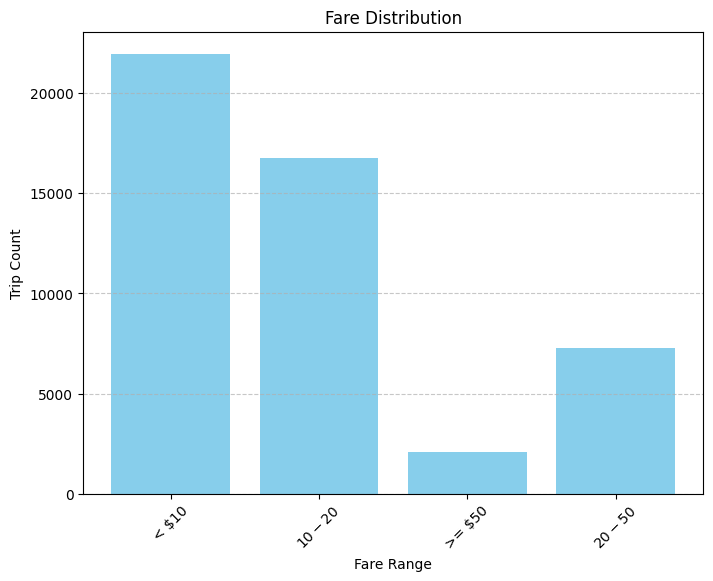

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the fare distribution Spark DataFrame to Pandas
fare_distribution_pd = fare_distribution.toPandas()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(fare_distribution_pd["fare_range"], fare_distribution_pd["count"], color="skyblue")
plt.title("Fare Distribution")
plt.xlabel("Fare Range")
plt.ylabel("Trip Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Hourly Trip Demand**

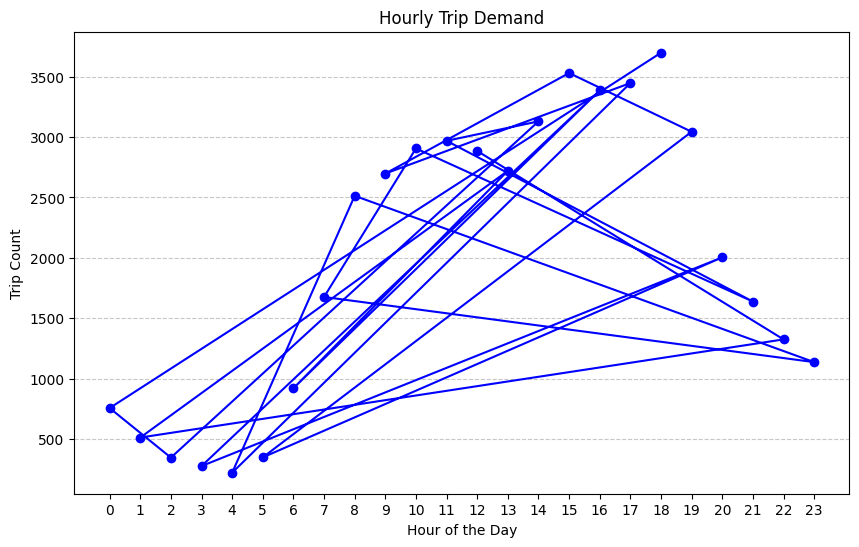

In [19]:
# Convert the hourly demand Spark DataFrame to Pandas
hourly_demand_pd = hourly_demand.toPandas()

# Plot the hourly demand
plt.figure(figsize=(10, 6))
plt.plot(hourly_demand_pd["pickup_hour"], hourly_demand_pd["trip_count"], marker="o", color="blue")
plt.title("Hourly Trip Demand")
plt.xlabel("Hour of the Day")
plt.ylabel("Trip Count")
plt.xticks(range(0, 24))  # Ensure all hours are shown
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**Relationship Between Trip Duration and Trip Distance**

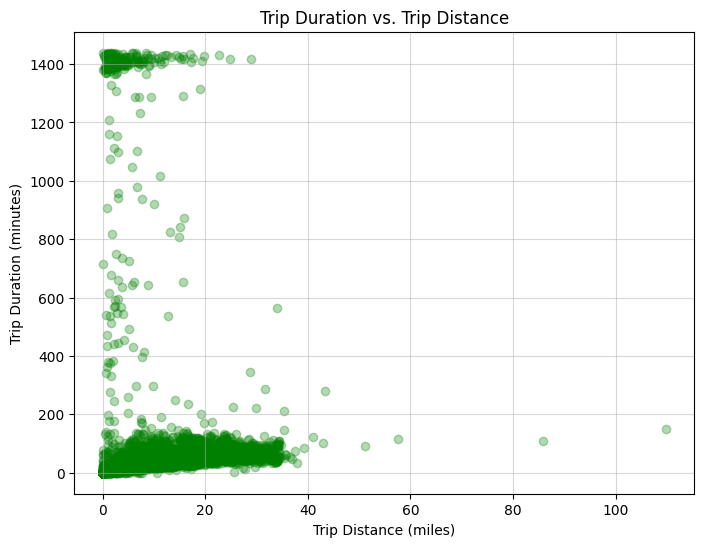

In [20]:
# Convert necessary columns to Pandas
trip_data_pd = df.select("trip_distance", "trip_duration_minutes").toPandas()

# Scatter plot of trip distance vs. trip duration
plt.figure(figsize=(8, 6))
plt.scatter(trip_data_pd["trip_distance"], trip_data_pd["trip_duration_minutes"], alpha=0.3, color="green")
plt.title("Trip Duration vs. Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Trip Duration (minutes)")
plt.grid(alpha=0.5)
plt.show()


# **Aggregation**

**Total Revenue Per Day**

In [21]:
from pyspark.sql.functions import date_format, sum

# Extract the pickup date from the timestamp
df = df.withColumn("pickup_date", date_format("pickup_datetime", "yyyy-MM-dd"))

# Group by the pickup date and calculate total revenue
daily_revenue = df.groupBy("pickup_date").agg(sum("fare_amount").alias("total_revenue"))

# Display the total revenue per day
print("Total revenue per day:")
daily_revenue.orderBy("pickup_date").show(10)  # Show the first 10 days


Total revenue per day:
+-----------+------------------+
|pickup_date|     total_revenue|
+-----------+------------------+
| 2008-12-31|              10.5|
| 2009-01-01|              89.5|
| 2021-06-07|              56.0|
| 2021-06-09|              56.0|
| 2021-06-10|             244.5|
| 2021-06-11|              98.0|
| 2021-07-01|          26834.95|
| 2021-07-02|          27547.24|
| 2021-07-03|          19180.54|
| 2021-07-04|16754.489999999998|
+-----------+------------------+
only showing top 10 rows



**Average Fare Per Mile**

In [22]:
from pyspark.sql.functions import avg

# Filter out trips with zero distance to avoid division errors
df_filtered = df.filter(df.trip_distance > 0)

# Create a new column for fare per mile
df_filtered = df_filtered.withColumn("fare_per_mile", df_filtered["fare_amount"] / df_filtered["trip_distance"])

# Calculate the average fare per mile
avg_fare_per_mile = df_filtered.select(avg("fare_per_mile").alias("avg_fare_per_mile"))

# Display the result
print("Average fare per mile:")
avg_fare_per_mile.show()


Average fare per mile:
+-----------------+
|avg_fare_per_mile|
+-----------------+
|9.077437964380788|
+-----------------+



**Comparison (Uber vs. Yellow Cab)**

**Simulate Fare Comparison**

In [24]:
from pyspark.sql.functions import hour

# Extract the hour of the day
df = df.withColumn("pickup_hour", hour("pickup_datetime"))

# Define peak hours (8 AM - 10 AM and 4 PM - 6 PM)
peak_hours = (df.pickup_hour >= 8) & (df.pickup_hour <= 10) | (df.pickup_hour >= 16) & (df.pickup_hour <= 18)

# Group by peak and non-peak hours to calculate average fare
peak_comparison = df.groupBy(
    when(peak_hours, "Peak Hours").otherwise("Non-Peak Hours").alias("time_period")
).agg(
    avg("fare_amount").alias("avg_fare"),
    count("*").alias("trip_count")
)

# Display the results
print("Fare comparison between peak and non-peak hours:")
peak_comparison.show()


Fare comparison between peak and non-peak hours:
+--------------+------------------+----------+
|   time_period|          avg_fare|trip_count|
+--------------+------------------+----------+
|    Peak Hours|14.670345974360359|     18643|
|Non-Peak Hours| 15.28876456401373|     29439|
+--------------+------------------+----------+



# **Optimization**

**Repartitioning**

In [25]:
# Repartition the dataset for better parallelism
optimized_df = df.repartition(10)

# Cache the optimized DataFrame for faster repeated operations
optimized_df.cache()

# Verify the number of partitions
print("Number of partitions after repartitioning:", optimized_df.rdd.getNumPartitions())


Number of partitions after repartitioning: 10


**Caching (Optional for Frequent Queries)**

In [26]:
# Cache the DataFrame in memory for repeated use
df.cache()

# Perform an operation to load the cache (optional)
df.count()  # Triggers caching

print("DataFrame cached successfully.")


DataFrame cached successfully.


# **Predictive Analysis**

**Prepare the Data**

In [27]:
from pyspark.sql.functions import hour
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Extract pickup hour as a feature
df = df.withColumn("pickup_hour", hour("pickup_datetime"))

# Select relevant columns and drop rows with missing values
ml_data = df.select("fare_amount", "trip_distance", "pickup_hour", "PULocationID").dropna()

# Combine features into a single vector column
feature_columns = ["trip_distance", "pickup_hour", "PULocationID"]
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
ml_data = vector_assembler.transform(ml_data)

# Final dataset for ML: 'features' and 'label'
ml_data = ml_data.select("features", "fare_amount").withColumnRenamed("fare_amount", "label")

# Display the first few rows of the ML dataset
print("First few rows of the ML dataset:")
ml_data.show(5)


First few rows of the ML dataset:
+-----------------+-----+
|         features|label|
+-----------------+-----+
|   [1.2,0.0,74.0]|  6.0|
|[13.69,0.0,116.0]| 42.0|
|  [0.95,0.0,97.0]|  6.5|
|  [1.24,0.0,74.0]|  6.5|
|   [1.1,0.0,42.0]|  7.0|
+-----------------+-----+
only showing top 5 rows



**Split the Data**

In [28]:
# Split the data into training (80%) and test (20%) sets
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Display the counts for each set
print(f"Training set count: {train_data.count()}, Test set count: {test_data.count()}")


Training set count: 38449, Test set count: 9633


**Train the Regression Model**

In [29]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")

# Train the model
lr_model = lr.fit(train_data)

# Display the coefficients and intercept
print("Linear Regression Model Coefficients:", lr_model.coefficients)
print("Linear Regression Model Intercept:", lr_model.intercept)


Linear Regression Model Coefficients: [2.963624863034061,0.013020308902665806,0.0019904243473993282]
Linear Regression Model Intercept: 3.8056369247435313


**Evaluate the Model**

In [30]:
# Make predictions on the test set
predictions = lr_model.transform(test_data)

# Display the first few predictions
print("Sample predictions:")
predictions.select("features", "label", "prediction").show(5)

# Evaluate the model using RMSE and R2 metrics
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 Score: {r2}")


Sample predictions:
+----------------+-----+-----------------+
|        features|label|       prediction|
+----------------+-----+-----------------+
| [0.01,2.0,25.0]| 20.0|3.911074399864187|
| [0.01,7.0,75.0]|  2.5|4.075697161747482|
|[0.01,7.0,119.0]|  2.5|4.163275833033053|
|[0.01,8.0,152.0]|  2.5|4.241980145399896|
| [0.01,9.0,95.0]| 20.0|  4.1415462665008|
+----------------+-----+-----------------+
only showing top 5 rows

Root Mean Squared Error (RMSE): 4.186814366399374
R2 Score: 0.9155126620423848


# **Clustering**

**Prepare Data for Clustering**

In [31]:
from pyspark.ml.clustering import KMeans

# Select relevant columns (PULocationID and trip_distance) for clustering
clustering_data = df.select("PULocationID", "trip_distance").dropna()

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=["PULocationID", "trip_distance"], outputCol="features")
clustering_data = vector_assembler.transform(clustering_data)

# Display the first few rows of the clustering dataset
print("First few rows of the clustering dataset:")
clustering_data.show(5)


First few rows of the clustering dataset:
+------------+-------------+-------------+
|PULocationID|trip_distance|     features|
+------------+-------------+-------------+
|          74|          1.2|   [74.0,1.2]|
|         116|        13.69|[116.0,13.69]|
|          97|         0.95|  [97.0,0.95]|
|          74|         1.24|  [74.0,1.24]|
|          42|          1.1|   [42.0,1.1]|
+------------+-------------+-------------+
only showing top 5 rows



**Train the K-Means Model**

In [32]:
# Initialize the K-Means model with 5 clusters
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=5, seed=42)

# Train the model
kmeans_model = kmeans.fit(clustering_data)

# Display the cluster centers
print("Cluster Centers:")
for center in kmeans_model.clusterCenters():
    print(center)


Cluster Centers:
[35.63347868  3.451401  ]
[172.21419952   4.21521319]
[77.63682659  2.99587063]
[126.36315348   5.14488957]
[241.48309889   5.71700399]


**Assign Clusters**

In [33]:
# Make predictions (assign clusters to each row)
clustered_data = kmeans_model.transform(clustering_data)

# Display the first few rows with cluster assignments
print("Cluster assignments:")
clustered_data.select("PULocationID", "trip_distance", "cluster").show(10)


Cluster assignments:
+------------+-------------+-------+
|PULocationID|trip_distance|cluster|
+------------+-------------+-------+
|          74|          1.2|      2|
|         116|        13.69|      3|
|          97|         0.95|      2|
|          74|         1.24|      2|
|          42|          1.1|      0|
|          24|          1.9|      0|
|          82|         0.66|      2|
|          74|         1.72|      2|
|          41|         1.37|      0|
|          74|         2.14|      2|
+------------+-------------+-------+
only showing top 10 rows

